In [2]:
import ipywidgets
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

plt.rc("figure", dpi=100)

# Motivación: aprovechar la información

Vamos a simular que medimos tiempos con un error de medición $\sigma = 1$:

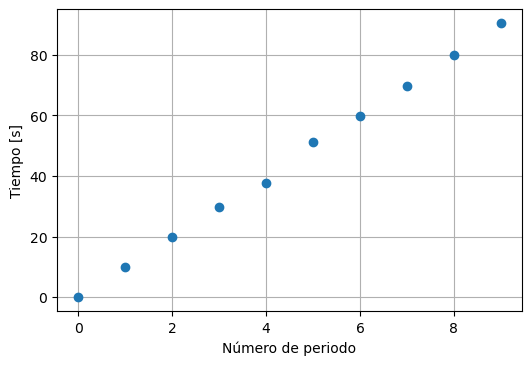

In [3]:
t = 10 * np.arange(10)
t = np.random.normal(t, scale=1)  # sigma = 1

plt.plot(t, "o")
plt.xlabel("Número de periodo")
plt.ylabel("Tiempo [s]")
plt.grid()

## Opción 1

Podriamos medir un solo periodo:

In [4]:
t[1] - t[0]

10.14984374123467

El error de 1 periodo es $\sigma_1 = \sqrt{2} \, \sigma$

## Opción pares

Podriamos medir muchos periodos y calcular el promedio solamente de los pares (para que sean independientes):

In [5]:
np.diff(t)[::2].mean()

10.84157870760823

cuyo error sería el error del promedio:

$$ \sigma_\bar{x} = \frac{\sigma_1}{\sqrt{N}} = \frac{\sqrt{2} \, \sigma}{\sqrt{N}} $$

## Opción "todos" (falsa)

Pero, ¿por qué descartar datos? ¡Usemos todos!

In [6]:
np.diff(t).mean()

10.069699283058325

Para calcular el error de este promedio, tendríamos que usar la fórmula completa de propagación.

Pero esto es equivalente a usar solo el primero y el último de los periodos (y la cantidad total):

$$ \begin{align}
\bar{x}
&= \frac{1}{N} \Big( T_1 + T_2 + \ldots + T_N \Big) \\
\text{reemplazando por los tiempos} \\
&= \frac{1}{N} \Big( (t_1 - t_0) + (t_2 - t_1) + \ldots + (t_N - t_{N-1}) \Big) \\
\text{simplificando} \\
&= \frac{t_N - t_0}{N}
\end{align} $$

In [7]:
(t[-1] - t[0]) / (t.size - 1)

10.069699283058325

cuyo error se puede obtener más facilmente:

$$ \sigma_{extremos} = \frac{\sqrt{\sigma^2 + \sigma^2}}{N} = \frac{\sqrt{2} \, \sigma}{N} = \frac{\sigma_1}{N} $$

## Opción todos (real)

¿Podemos aprovechar los puntos intermedios para algo?

# Cuadrados mínimos

¿Cuándo podemos hacer un promedio?

Para el péndulo teniamos la siguiente relación entre la longitud $L$, el periodo $T$ y la aceleración de la gravedad $g$:

$$ g(T, L) = (2\pi)^2 \, \frac{L}{T^2} $$

o, despejando el periodo:

$$ T(L, g) = 2\pi \, \sqrt{\frac{L}{g}} $$

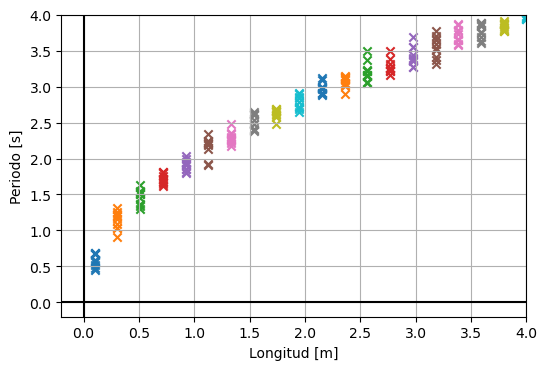

In [5]:
def T(L, g=9.81):
    return 2 * np.pi * np.sqrt(L / g)

fig, ax = plt.subplots()

# longitud = [1, 2, 3]
longitud = np.linspace(0.1, 4, 20)

for L in longitud:
    periodo = np.random.normal(loc=T(L), scale=0.1, size=10)
    ax.scatter(np.full_like(periodo, L), periodo, marker="x")

ax.set(xlim=(-0.2, 4), ylim=(-0.2, 4),
          xlabel="Longitud [m]", ylabel="Periodo [s]")
ax.axhline(0, color="k")
ax.axvline(0, color="k")
ax.grid()

## Para una constante

Si tenemos un set de mediciones $y_i = \{ y_1, y_2, \ldots, y_N \}$,

y queremos encontrar el valor $c$ "más cercano" a todos:

In [6]:
y = np.random.normal(10, scale=1, size=10)
x = np.arange(y.size)

@ipywidgets.interact(c=(5, 15, 0.25))
def _(c):
    plt.errorbar(x, y, yerr=(y - c, np.zeros_like(x)), fmt="o")
    plt.axhline(c, color="C1")
    plt.ylim(5, 15)
    plt.grid()

interactive(children=(FloatSlider(value=10.0, description='c', max=15.0, min=5.0, step=0.25), Output()), _dom_…

podemos usar el criterio de cuadrados mínimos:

$$ \begin{align}
S(c)
&= \sum_i (y_i - c)^2
\end{align} $$

$$ \frac{S(c)}{dc} = 0 $$

y llegamos a que el valor que mínimiza $S(c)$ es $c = \bar{y} = \frac{1}{N} \sum_i y_i$, el promedio.

## Para una lineal

$$ y(x) = A x $$

In [23]:
A_real = 2

x = np.arange(10)
y = A_real * x

# np.random.seed(42)
y = np.random.normal(y, scale=1)

@ipywidgets.interact(A=(0, 3, 0.25))
def _(A):
    plt.scatter(x, y)
    plt.plot(x, A * x, color="C1")
    plt.errorbar(x, y, yerr=(y - A * x, np.zeros_like(x)), fmt="o", color="C0")
#     plt.ylim(-3, 25)
    plt.axhline(0, color="k")
    plt.axvline(0, color="k")
    plt.grid()

interactive(children=(FloatSlider(value=1.0, description='A', max=3.0, step=0.25), Output()), _dom_classes=('w…

Hagamos la cuenta:

$$ \begin{align}
S(A)
&= \sum_i (y_i - Ax_i)^2 \\
\\
0 &= \frac{d S(A)}{d A} \\
\text{reemplazamos} \\
&= \frac{d \sum_i (y_i - Ax_i)^2}{d A} \\
\text{distribuimos} \\
&= \sum_i \frac{d (y_i - Ax_i)^2}{d A} \\
\text{regla de la cadena} \\
&= \sum_i 2 \, (y_i - Ax_i) \, (-x) \\
\text{reagrupando} \\
&= -2 \Big( \sum_i x_i y_i - A \sum_i x_i^2 \Big) \\
\end{align} $$

Si despejamos $A$:

$$ \begin{align}
A &= \frac{\sum_i x_i y_i}{\sum_i x_i^2} \\
\\
\sigma_A^2 &= \ldots (\text{propagando el error de }y_i)
\end{align} $$

In [24]:
(x * y).sum() / (x**2).sum()

1.9379146982354158

Pero, más facilmente, y sin hacer ninguna cuenta, pueden usar la función `curve_fit`, que importamos antes:

In [25]:
def lineal(x, A):
    return A * x

A, var_A = curve_fit(lineal, x, y)
sigma_A = np.sqrt(np.diag(var_A))

A, sigma_A

(array([1.9379147]), array([0.04569351]))

In [26]:
(A - A_real) / sigma_A

array([-1.35873344])

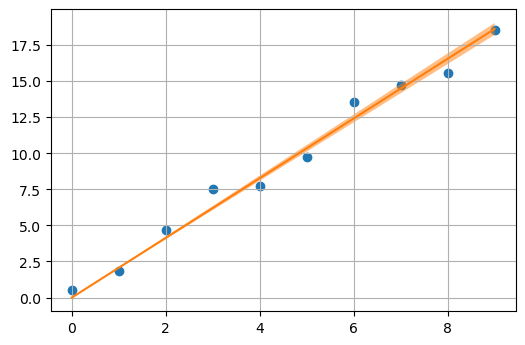

In [15]:
plt.scatter(x, y)
plt.plot(x, lineal(x, A), color="C1")
plt.fill_between(x, lineal(x, A - sigma_A), lineal(x, A + sigma_A), alpha=0.5)
plt.grid()

## Cuadrados mínimos en general

En general, uno puede ajustar cualquier relación que quiera:

$$ y = f(x_i, p_0, p_1, \ldots, p_k) $$

donde $p_0, p_1, \ldots, p_N$ son los parametros a determinar.

Siempre se busca minimizar la diferencia entre el $y_i$ medido y la función evaluada en el $x_i$ correspondiente:
$$ \begin{align}
S(p_0, p_1, \ldots, p_k)
&= \sum_i \Big( \; y_i - f(x_i, p_0, p_1, \ldots, p_k) \; \Big)^2
\end{align} $$

Recién vimos cuando $ f(x, A) = A x $.

El promedio es un caso particular, donde la función no depende de $x$: $ f(x, C) = C $

## Para una recta

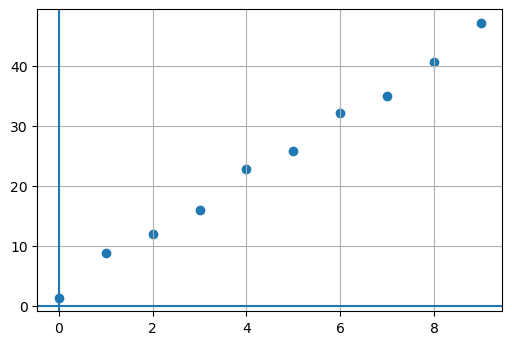

In [27]:
x = np.arange(10)
y = 5 * x + 2
y = np.random.normal(y, scale=1)

plt.scatter(x, y)
plt.axhline(0)
plt.axvline(0)
plt.grid()

In [28]:
def recta(x, a, b):
    return a * x + b

parametros, covarianza = curve_fit(recta, x, y)

In [29]:
parametros

array([4.86029898, 2.31854793])

In [30]:
np.sqrt(np.diag(covarianza))

array([0.12427949, 0.66347096])

In [31]:
covarianza

array([[ 0.01544539, -0.06950427],
       [-0.06950427,  0.44019372]])

## Para un polinomio de orden N

Si queremos ajustar un polinomio de orden $N$:

$$ y(x) = a_0 + a_1 x + a_2 x^2 + \ldots + a_N x^N = \sum_{i=0}^N a_i x^i $$

podemos usar la función `np.polyfit`:

In [34]:
np.polyfit(x, y, 3)

array([ 0.0255321 , -0.32675905,  5.87601007,  1.89023065])

## Sobreajuste

In [36]:
x = np.arange(10)
y = np.random.normal(x, scale=1)

@ipywidgets.interact(orden=(1, x.size - 1))
def _(orden=1):
    p = np.polyfit(x, y, orden)
    t = np.linspace(x[0], x[-1], 100)
    plt.plot(t, np.polyval(p, t))
    plt.scatter(x, y)
    plt.grid()

interactive(children=(IntSlider(value=1, description='orden', max=9, min=1), Output()), _dom_classes=('widget-…

## Residuos

¿Cómo podemos evaluar si un modelo es "correcto"?

O, mejor dicho, ¿cómo podemos evaluar si un modelo es incorrecto?

Veamos el caso del péndulo. Imaginemos que medimos el periodo en función de la longitud:

Text(0, 0.5, 'Periodo [s]')

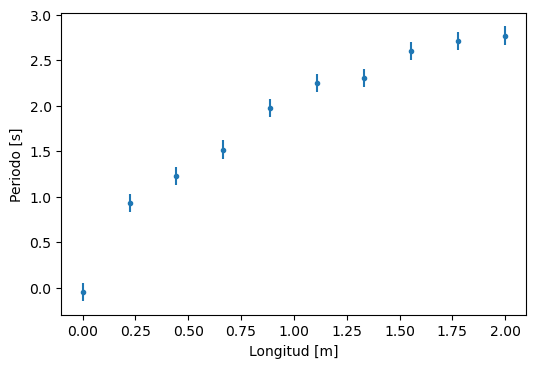

In [37]:
def periodo_pendulo(L, g=9.81):
    return 2 * np.pi * np.sqrt(L / g)

longitud = np.linspace(0, 2, 10)
periodo = periodo_pendulo(longitud)
periodo = np.random.normal(loc=periodo, scale=0.1)

plt.errorbar(longitud, periodo, yerr=0.1, fmt=".")

plt.xlabel("Longitud [m]")
plt.ylabel("Periodo [s]")

Pero proponemos un modelo incorrecto. En lugar de $T(L) \propto \sqrt{L}$, decimos $T(L) \propto L$

Text(0, 0.5, 'Periodo [s]')

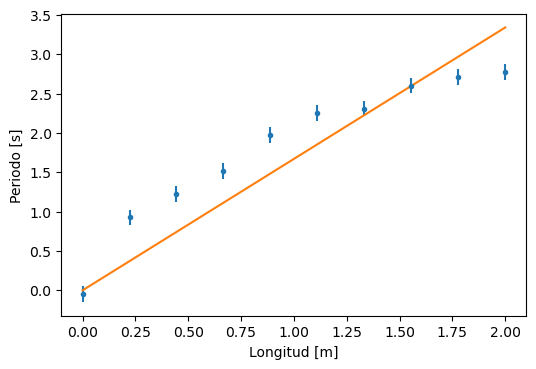

In [40]:
def lineal(x, A):
    return A * x

params, covarianza = curve_fit(lineal, longitud, periodo)

plt.errorbar(longitud, periodo, yerr=0.1, fmt=".")
plt.plot(longitud, lineal(longitud, *params))

plt.xlabel("Longitud [m]")
plt.ylabel("Periodo [s]")

Una de las cosas quese mira es que las mediciones (azul) queden distribuidas aleatoriamente por arriba y por debajo del modelo (naranja), sin ningun patrón.

Una forma más cómoda de verlo es calculando los residuos $ r_i = y_i - f(x_i, A) $, que son la diferencia entre las mediciones y el modelo.

En este caso, $r_i = y_i - A x_i$

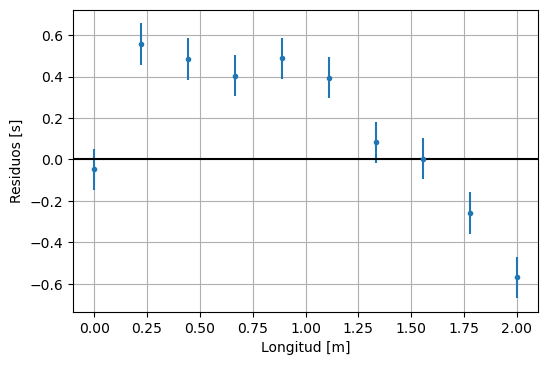

In [41]:
residuos = periodo - lineal(longitud, *params)

plt.errorbar(longitud, residuos, yerr=0.1, fmt=".")

plt.axhline(0, color="k")
plt.xlabel("Longitud [m]")
plt.ylabel("Residuos [s]")
plt.grid()

Lo que se quiere ver al mirar los residuos es que esten **distribuidos aleatoriamente alrededor del 0**.

También se dice que los residuos **no tengan estructura**.

Pongamos todo junto en un gráfico.

Text(0.5, 0, 'Longitud [m]')

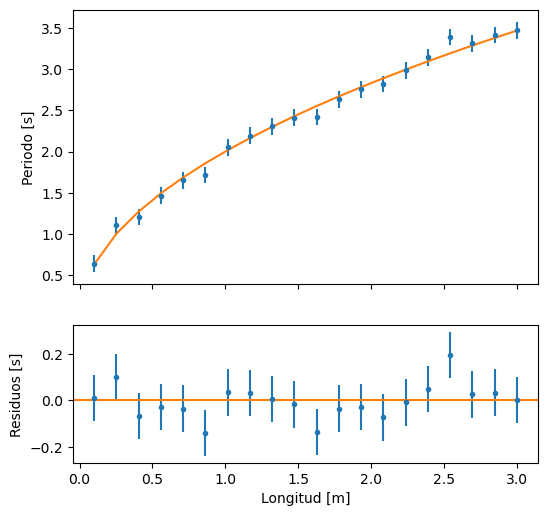

In [43]:
longitud = np.linspace(0.1, 3, 20)
periodo = periodo_pendulo(longitud)
periodo = np.random.normal(loc=periodo, scale=0.1)

def func(x, A):
    return A * np.sqrt(x)

params, covarianza = curve_fit(func, longitud, periodo)


fig, ax = plt.subplots(2, 1, sharex=True, figsize=(6, 6), gridspec_kw={"height_ratios": [2, 1]})

ax[0].errorbar(longitud, periodo, yerr=0.1, fmt=".")
ax[0].plot(longitud, func(longitud, *params))
ax[0].set_ylabel("Periodo [s]")

ax[1].errorbar(longitud, periodo - func(longitud, *params), yerr=0.1, fmt=".")
ax[1].axhline(0, color="C1")
ax[1].set_ylabel("Residuos [s]")
ax[1].set_xlabel("Longitud [m]")

Comentarios:

- Como comparten el eje x, es mejor graficar los residuos debajo del ajuste.
- Siempre hay que graficar los datos "originales" (el de arriba), no solo los residuos.
- Los residuos se pueden incluir, o hacer este gráfico completo en un apénice.

## Estimando el error de las mediciones $y_i$

### Para una constante

Si recuerdan de la clase anterior, la desviación estandar era la "desviación promedio de los datos $y_i$". A partir del método de cuadrados mínimos:

$$ S(c) = \sum_i (y_i - c)^2 $$

se encontraba el valor óptimo:

$$ c_{min} = \bar{y} $$

y evaluando la suma de cuadrados mínimos en este valor óptimo y dividiendo por $N$, se podia llegar a la varianza, o el cuadrado de la desviación estandar:

$$ \sigma^2 = \frac{1}{N} \, S(\bar{y}) = \frac{1}{N} \sum_i^N (y_i - \bar{y})^2 = \frac{1}{N} \sum_i^N r_i^2 $$

que no es otra cosa que el promedio del cuadrado de los residuos.

### Para una lineal

Análogamente, podemos hacerlo para una función lineal:

$$ S(c) = \sum_i (y_i - A x_i)^2 $$

$$ c_{min} = \bar{y} $$

$$ \sigma^2 = \frac{1}{N} \, S(\bar{y}) = \frac{1}{N} \sum_i^N (y_i - \bar{y})^2 = \frac{1}{N} \sum_i^N r_i^2 $$

### En general

O en general:

$$ S(c) = \sum_i \Big(y_i - f(x_i, p_0, \ldots) \Big)^2 $$

$$ \sigma^2 = \frac{1}{N} \, S\Big(p_0^{min}, \ldots \Big) = \frac{1}{N} \sum_i^N r_i^2 $$

¡Pero ojo! Esto es solo válido si el modelo (la función $f$) es la "correcta". Es decir, si no es la incorrecta, si los residuos no tienen estructura.

# Ejercicios y preguntas

## Ejemplo en Colab

Genere un set de datos para que prueben realizar un ajuste.

En este Colab está el código de ejemplo: https://colab.research.google.com/drive/1kiqQuIhcEv9Cfab1BpUKfLCAoIdp196T

Si no quieren usar Colab, pueden bajar los datos desde aquí en formato .zip: http://users.df.uba.ar/maurosilber/docencia/labo1/20210908/datos.zip

## Para rehacer con sus datos del periodo del péndulo

1. Chequear si era valido promediar periodos. ¿Cómo?
2. Ajustar el tiempo en función del número de periodo para obtener un mejor valor del periodo del péndulo.
3. Calcular la aceleración de la gravedad $g$ con este nuevo valor, y contestar a cuántos $\sigma$ quedó del valor esperado: $g=9.81 \frac{m}{s^2}$.